## Global update with `Dask`

`Dask` is a framework that allows to add parallelization to code in Python. To install the extra dependencies (not added in `pyproject.toml` yet):

In [ ]:
%%bash
python -m pip install dask distributed --upgrade

`graphviz` (or `cytoscape`) is also needed to visualize the task graph.

In [1]:
from dask.distributed import Client, LocalCluster

client = Client()
client # Displays the information of the local client

/home/jofrevalles/anaconda3/envs/tnad_gradient/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38135 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38135/status,
Dashboard: http://127.0.0.1:38135/status,Workers: 4
Total threads: 4,Total memory: 15.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45071,Workers: 4
Dashboard: http://127.0.0.1:38135/status,Total threads: 4
Started: Just now,Total memory: 15.51 GiB
Comm: tcp://127.0.0.1:46059,Total threads: 1
Dashboard: http://127.0.0.1:32901/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:46779,


This creates automatically a Dask 'Client' given by our system specificaition. One can then go to the link in the previous block to see `Dask dashboard`, which enables us to see the task stream and other useful information live during the computation.

`procedures.py` functions adapted to Dask framework:

In [2]:
import itertools
import FeatureMap as fm
from losses import loss_miss, loss_reg
from gradients import gradient_miss, gradient_reg
import math
import quimb.tensor as qtn
import quimb as qu
import dask 

def local_update_sweep_dyncanonization_renorm(P, n_epochs, n_iters, data, batch_size, alpha, lamda_init, bond_dim, decay_rate=None, expdecay_tol=None):
    N_features = P.nsites
    
    loss_array = []
    for epoch in range(n_epochs):
        for it in range(n_iters):
            # define sweeps
            sweeps = itertools.chain(zip(list(range(0,N_features-1)), list(range(1,N_features))), reversed(list(zip(list(range(1,N_features)),list(range(0,N_features-1))))))
            for sweep_it, sites in enumerate(sweeps):
                [sitel, siter] = sites
                site_tags = [P.site_tag(site) for site in sites]
                # canonize P with root in sites
                ortog_center = sites
                P.canonize(sites, cur_orthog=ortog_center)
                # copy P as reference
                P_ref = P.copy(deep=True)
                # pop site tensor
                [origl, origr] = P.select_tensors(site_tags, which="any")
                tensor_orig = origl & origr ^ all
                # memorize bond between 2 selected sites
                bond_ind_removed = P.bond(site_tags[0], site_tags[1])

                #virtual bonds
                #    left
                if sitel == 0 or (sitel == N_features-1 and sitel>siter): vindl = []
                elif sitel>0 and sitel<siter: vindl = [P.bond(sitel-1, sitel)]
                else: vindl = [P.bond(sitel, sitel+1)]
                #    right
                if siter == N_features - 1 or (siter == 0 and siter<sitel): vindr = []
                elif siter < N_features-1 and siter>sitel: vindr = [P.bond(siter, siter+1)]
                else: vindr = [P.bond(siter-1, siter)]

                # remove site tags of poped sites
                P.delete(site_tags, which="any")

                grad_miss=0; loss_miss_batch=0
                for sample in data[it]:
                    # create MPS for input sample
                    phi, _ = fm.embed(sample.flatten(), fm.trigonometric)
                    
                    #calculate loss
                    loss_miss_batch += loss_miss(phi, P_ref)
                    
                    #calculate gradient
                    grad_miss += gradient_miss(phi, P_ref, P, sites, N_features)
                # total loss
                loss = (1/batch_size)*(loss_miss_batch) + loss_reg(P_ref, alpha)
                loss_array.append(loss)
                
                # gradient of loss miss
                grad_miss.drop_tags()
                grad_miss.add_tag(site_tags[0]); grad_miss.add_tag(site_tags[1])
                # gradient of loss reg
                grad_regular = gradient_reg(P_ref, P, alpha, sites, N_features)
                if grad_regular != 0:
                    grad_regular.drop_tags()
                    grad_regular.add_tag(site_tags[0]); grad_regular.add_tag(site_tags[1])
                # total gradient
                total_grad = (1/batch_size)*grad_miss + grad_regular

                # update tensor
                if decay_rate != None:
                    if epoch > expdecay_tol:
                        # exp. decay of lamda
                        lamda = lamda_init*math.pow((1 - decay_rate/100),epoch)
                        tensor_new = tensor_orig - lamda*total_grad
                else:
                    tensor_new = tensor_orig - lamda_init*total_grad

                # normalize updated tensor
                tensor_new.normalize(inplace=True)

                # split updated tensor in 2 tensors
                lower_ind = [f'b{sitel}'] if f'b{sitel}' in P.lower_inds else []
                [tensorl, tensorr] = tensor_new.split(get="tensors", left_inds=[*vindl, P.upper_ind(sitel), *lower_ind], bond_ind=bond_ind_removed, max_bond=bond_dim)

                # link new tensors to P back
                for site, tensor in zip(sites, [tensorl, tensorr]):
                    tensor.drop_tags()
                    tensor.add_tag(P.site_tag(site))
                    P.add_tensor(tensor)
    return P, loss_array

def get_sample_loss_grad(sample, embed_func, P, P_rem, site):
    # create MPS for input sample
    phi, _ = fm.embed(sample.flatten(), embed_func)

    #calculate loss
    loss_miss_batch = loss_miss(phi, P)

    #calculate gradient
    grad_miss = gradient_miss(phi, P, P_rem, [site])
    return loss_miss_batch, grad_miss

def get_total_loss_grad(P, site, data, embed_func, batch_size, alpha):
    P_rem = P.copy(deep=True)
    
    site_tag = P_rem.site_tag(site)
    # remove site tag of poped sites
    P_rem.delete(site_tag, which="any")

    # paralelize
    loss_miss = []; grad_miss = []
    for i, sample in enumerate(data):
        output_per_sample = dask.delayed(get_sample_loss_grad)(sample, embed_func, P, P_rem, site)
        loss_miss.append(output_per_sample[0])
        grad_miss.append(output_per_sample[1])
    
    total_loss_miss = dask.delayed(sum)(loss_miss)
    total_grad_miss = dask.delayed(sum)(grad_miss)

    # total loss
    total_loss = (1/batch_size)*(total_loss_miss) + loss_reg(P, alpha)

    # gradient of loss miss
    grad_miss = total_grad_miss

    grad_miss.drop_tags()
    grad_miss.add_tag(site_tag)
    # gradient of loss reg
    grad_regular = gradient_reg(P, P_rem, alpha, [site])
    if grad_regular != 0:
        grad_regular.drop_tags()
        grad_regular.add_tag(site_tag)
    # total gradient
    total_grad = (1/batch_size)*(grad_miss) + grad_regular
    return total_loss, total_grad

def global_update_costfuncnorm(P, n_epochs, n_iters, data, batch_size, alpha, lamda_init, bond_dim, decay_rate=None, expdecay_tol=None):
    loss_array = []
    n_tensors = P.nsites
    
    for epoch in range(n_epochs):
        for it in range(n_iters):            
            # paralelize
            loss = []; grad_per_site=[]
            for site in range(n_tensors):
                embed_func = fm.trigonometric
                output_per_site = get_total_loss_grad(P, site, data[it], embed_func, batch_size, alpha)
                loss.append(output_per_site[0])
                grad_per_site.append(output_per_site[1])
            
            sum_loss = dask.delayed(sum)(loss)
            loss_array.append(sum_loss/n_tensors)

            # update P
            # no need to paralelize
            for site in range(n_tensors):
                site_tag = P.site_tag(site)
                tensor_orig = P.select_tensors(site_tag, which="any")
                
                if epoch > expdecay_tol:
                    if decay_rate != None:
                        # exp. decay of lamda
                        lamda = lamda_init*math.pow((1 - decay_rate/100),epoch)
                        tensor_orig = tensor_orig - lamda*grad_per_site[site]
                else:
                    tensor_orig = tensor_orig - lamda_init*grad_per_site[site]
        
    return P, loss_array

Arguments for the optimization process:

In [3]:
# args
train_size=64
batch_size=32
strides=(4,4)
pool_size=(2,2)
padding='same'
reduced_shape=(7,7)
opt_procedure = 'global_update_costfuncnorm'
spacing=3
n_epochs=2
alpha=0.4
lamda_init=2e-3
decay_rate=0.01
expdecay_tol = 10
bond_dim=5
init_func='normal'
scale_init_p=0.5

Now since we are using `dask.delayed()` the computation will be done lazily:

In [5]:
%%time

from optimization import train_SMPO, load_mnist_train_data, data_preprocessing
# 
train_data = load_mnist_train_data(train_size=train_size)
data = data_preprocessing(train_data, strides=strides, pool_size=pool_size, padding=padding, reduced_shape=reduced_shape)

if opt_procedure == 'local_2sitesweep_dynamic_canonization_renorm':
        opt_procedure = local_2sitesweep_dynamic_canonization_renorm
elif opt_procedure == 'global_update_costfuncnorm':
    opt_procedure = global_update_costfuncnorm

P, loss_array = train_SMPO(data, spacing, n_epochs, alpha, opt_procedure, lamda_init, decay_rate, expdecay_tol, bond_dim, init_func, scale_init_p, batch_size)
loss_array

CPU times: user 12.1 s, sys: 890 ms, total: 13 s
Wall time: 13.1 s


[Delayed('truediv-f86aca2f8718e01e498e635823baf2ef'),
 Delayed('truediv-c2dfd82fba30bb470b1cc9c169bd0723'),
 Delayed('truediv-f642131e9894a6d3c3294147c54bcc37'),
 Delayed('truediv-02b70220321b35c4aa9dd12e277d78ac')]

Now to obtain the actual values of `P` and `loss_array` we need to call `.compute()`. We can also see the task graph of the job: (needs `graphviz` installed)

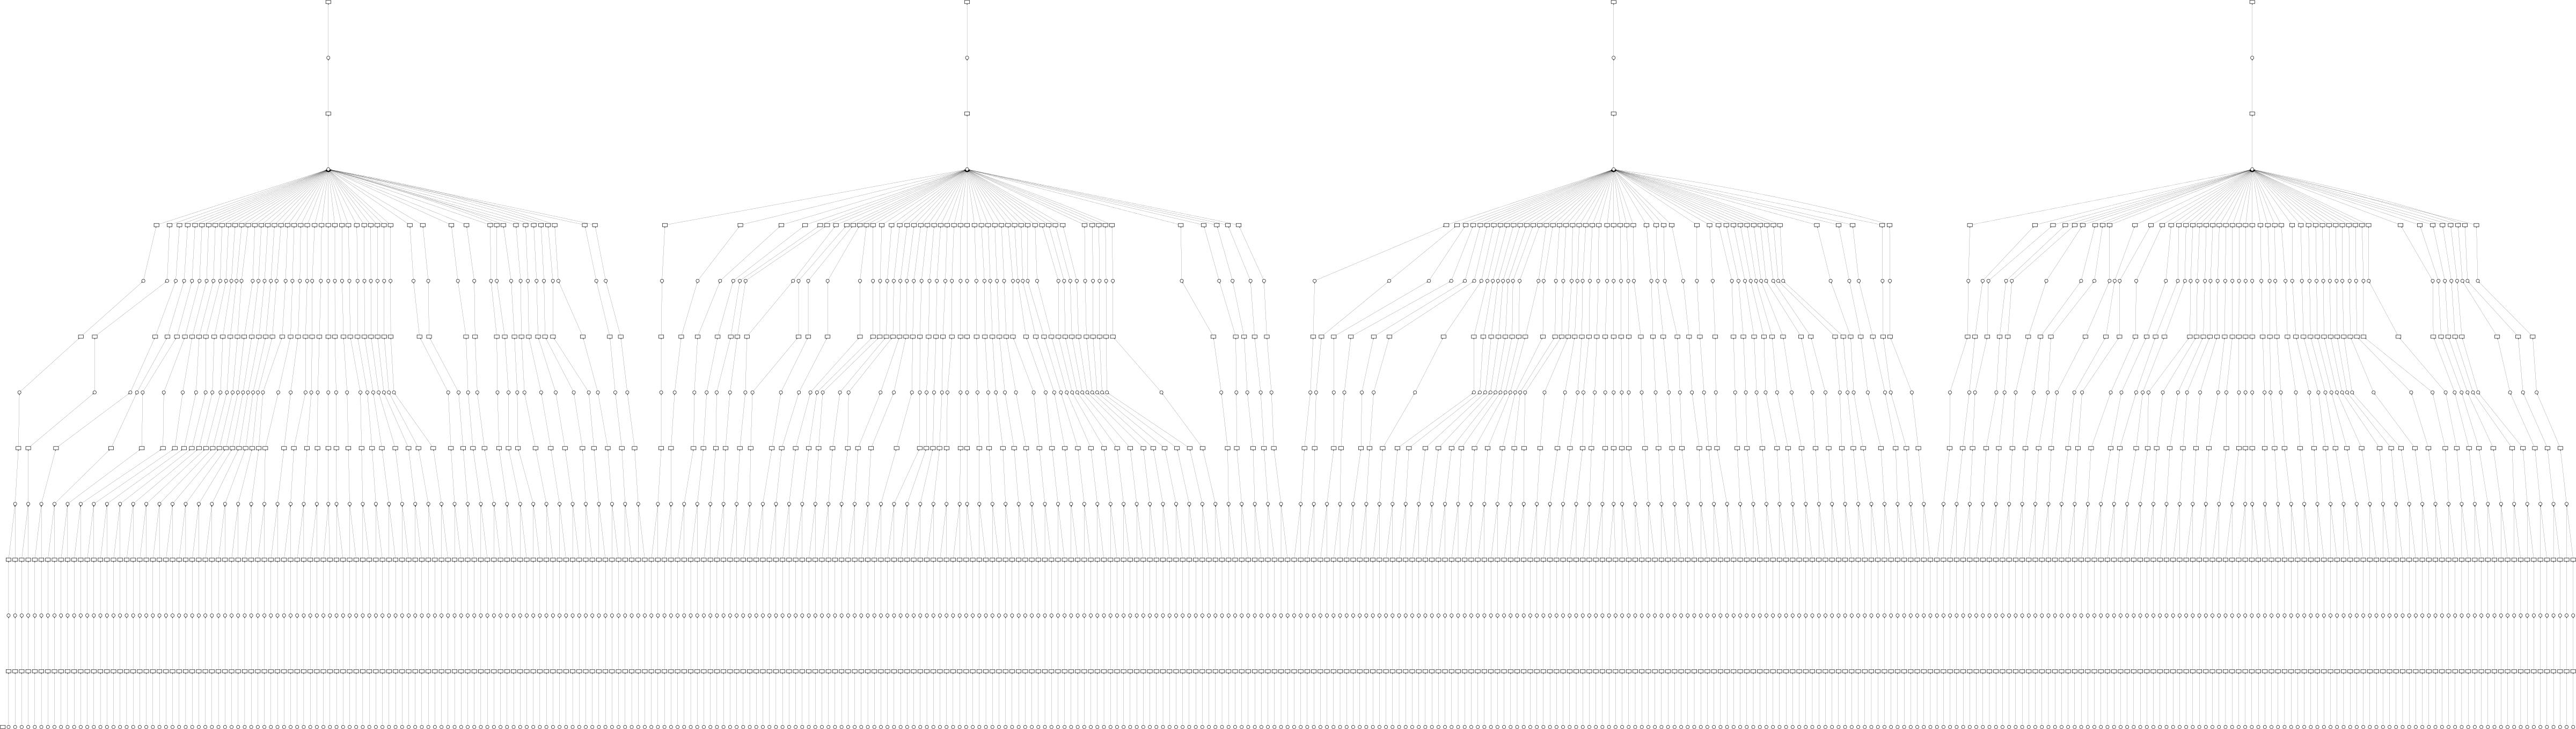

In [6]:
loss_array = dask.delayed()(loss_array)
loss_array.visualize(size='50',ranksep='8',node_attr={'fillcolor':'black','fontsize':'0','penwidth':'4','color':'black'},filename='visualization_graph.png', optimize_graph=True)

And we can begin the computation. `performance_report` enables to save some information from the Dask dashboard in an `.html` file.

In [7]:
%%time

from dask.distributed import performance_report

with performance_report(filename='performance_report.html') as ts:
    loss_array = dask.delayed()(loss_array)
    loss_array = loss_array.compute()

CPU times: user 9.52 s, sys: 970 ms, total: 10.5 s
Wall time: 50.3 s


The `performance_report.html` file will look something like this:


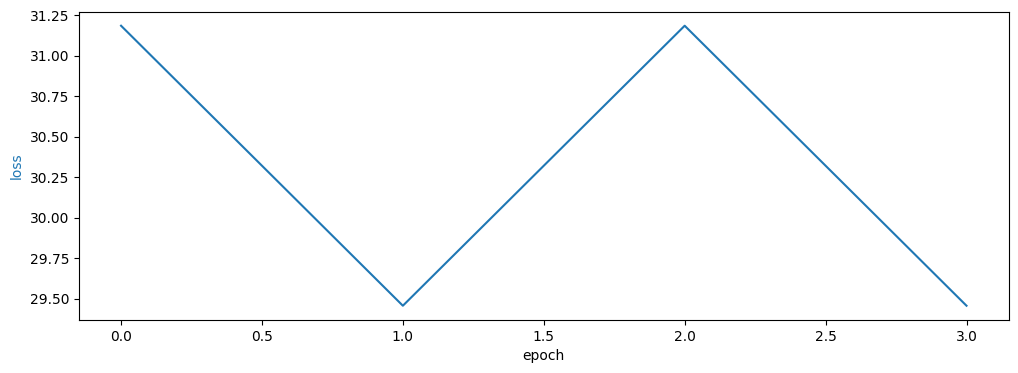

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.xlabel("epoch")
plt.ylabel("loss", color="tab:blue")
plt.plot(range(0, len(loss_array)), loss_array)
plt.show()